# Baseline Neural Network Setup using k-fold Cross Validation

In [29]:
# library dependencies
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import lzma
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow as tf
import keras_tuner
import math
import time

In [2]:
# method to store data as serialized binary structure lzma compressed
def can_pickles(data, filename):
    with lzma.LZMAFile(filename, 'wb') as f:
        pickle.dump(data, f, pickle.DEFAULT_PROTOCOL)

# method to retrieve data from a compressed pickle file (created with the method above)
def uncan_pickles(filename):
    with lzma.LZMAFile(filename, 'rb') as f:
        return pickle.load(f)

In [3]:
# helper method to create a valid dataset
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

# method to create a TF dataset
def create_dataset(X_np_array, y_np_array, batch_size=32, sort=False):
    # sort the arrays
    if sort == True:
        # build an array containing the sequence lengths
        sequence_lengths = list(map(lambda x: len(x), X_np_array))
        # sort the array but only get the indices
        sorted_indices = np.argsort(sequence_lengths)
        # now sort the X and y train arrays according to the sorted indicds
        X_np_array = X_np_array[sorted_indices]
        y_np_array = y_np_array[sorted_indices]

    # create ragged tensor from in-homogeneous array
    X_tensor = tf.ragged.constant(X_np_array, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
    
    # create dataset
    ds = tf.data.Dataset.from_tensor_slices((X_tensor, y_np_array))

    # create a dataset of dense tensors
    ds = ds.map(reformat)

    # apply padded batching to the dataset
    ds = ds.padded_batch(batch_size)
    
    return ds

In [4]:
# method to plot two MAE arrays
def plot_loss(train_mae, val_mae, start_epoch=1):
    # get the number of epochs the training ran
    epochs = range(start_epoch, len(train_mae) + 1)
    # plot the graph
    plt.plot(epochs, train_mae, "bo", label="Training")
    plt.plot(epochs, val_mae, "b", label="Validation")
    plt.title("Training and Validation Mean Absolute Error")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

In [23]:
# model to work with
# from keras-tuner run:
#   conv_units: 424
#   kernel_size: 30
#   rate: 0.30000000000000004
#   dense_units: 128
def augur_model():
    inputs = layers.Input(shape=(None, 4))
    conv1 = layers.Conv1D(
        filters=424,
        kernel_size=30,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs)
    norm1 = layers.BatchNormalization()(conv1)
    drop1 = layers.Dropout(
        rate=0.3
    )(norm1)
    # pool1 = layers.MaxPooling1D(
    #     pool_size=4,
    #     strides=4
    # )(drop1)
    pool1 = layers.GlobalMaxPool1D()(drop1)
    # flat = layers.Flatten()(drop1)
    dense = layers.Dense(128, activation='relu')(pool1)
    outputs = layers.Dense(1)(dense)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='Test')

    return model

In [43]:
def dan_zrimec_model():
    inputs = layers.Input(shape=(None, 4))
    # 1D convolution
    conv = layers.Conv1D(
        filters=392,
        kernel_size=3, 
        strides=1, 
        activation='relu'
    )(inputs)
    # batch normalization
    norm = layers.BatchNormalization()(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(norm)
    # dropout
    drop = layers.Dropout(
        rate=0.4
    )(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=192, 
            return_sequences=True, 
            recurrent_dropout=0.25
        ),
        merge_mode='mul'
        # input_shape=(8000, 4),
    )(drop)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=20,
        strides=None
    )(bilstm)
    drop = layers.Dropout(
        rate=0.35
    )(pool)
    # flatten
    # flat = layers.Flatten()(drop)
    gmp = layers.GlobalMaxPool1D()(drop)
    # fully connected
    dense = layers.Dense(
        units=128,
        activation='relu',
    )(gmp)
    # batch normalization
    norm = layers.BatchNormalization()(dense)
    # dropout
    drop = layers.Dropout(
        rate=0.3
    )(norm)
    # dense
    outputs = layers.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='BaselineModel')

    return model

In [45]:
def dan_zrimec_model2():
    inputs = layers.Input(shape=(None, 4))
    # 1D convolution
    conv = layers.Conv1D(
        filters=256,
        kernel_size=21, 
        strides=1, 
        activation='relu'
    )(inputs)
    # batch normalization
    norm = layers.BatchNormalization()(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(norm)
    # dropout
    drop = layers.Dropout(
        rate=0.25
    )(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=512, 
            return_sequences=True, 
            recurrent_dropout=0.3
        ),
        merge_mode='sum'
        # input_shape=(8000, 4),
    )(drop)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(bilstm)
    drop = layers.Dropout(
        rate=0.1
    )(pool)
    # flatten
    # flat = layers.Flatten()(drop)
    gmp = layers.GlobalMaxPool1D()(drop)
    # fully connected
    dense = layers.Dense(
        units=72,
        activation='relu',
    )(gmp)
    # batch normalization
    norm = layers.BatchNormalization()(dense)
    # dropout
    drop = layers.Dropout(
        rate=0.55
    )(norm)
    # dense
    outputs = layers.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='BaselineModel')

    return model

In [8]:
def run_model(model, train_ds, val_ds, epochs=10, start_epoch=1, oneshot=True, verbose=True):
    if verbose: 
        model.summary()
        verbose_fit = 'auto'
    else:
        verbose_fit = 0
    
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
        
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        verbose=verbose_fit
    )
    
    if oneshot == True:
        plot_loss(
            history.history['mean_absolute_error'],
            history.history['val_mean_absolute_error'],
            start_epoch
        )
    else:
        return history.history['mean_absolute_error'], history.history['val_mean_absolute_error']

In [33]:
# simple timer from https://realpython.com/python-timer/

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            print(f"Timer is running. Use .stop() to stop it")
        else:
            self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
        else:
            elapsed_time = time.perf_counter() - self._start_time
            self._start_time = None
            print(f"    elapsed time: {elapsed_time:0.4f} seconds")

## Data Prep

*explain it in more detail*

X holds a list of sequences one hot encoded

y holds a list of PTR values as floats

In [9]:
# read the prepared data back
X = uncan_pickles('../data/onehot_x_lung.pickle.xz')
y = uncan_pickles('../data/onehot_y_lung.pickle.xz')

In [10]:
# build an inhomogenous numpy array from X
X = np.array(X, dtype=object)

In [11]:
# convert type of target values from string to float
y = np.array(y).astype(float)

Random sample from X and y.

In [12]:
X[0]

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [13]:
y[0]

7.544

In [14]:
# count of input sequences
len(X)

8201

### Baseline PTR

There is no common sense approach in finding a baseline for the protein-to-mRNA ratio of a particular mRNA sequence. This is what the *Basic Neural Network* approach is for - to determin a baseline and see if a slightly adapted neural network with feature engineered input can provide better predictions.

But what can be done is to simply check the value range of the target PTRs, calculate mean and standard deviation. Given that the standard deviation is  small (12.5% of the value range) one can (stupidly) predict the mean value every time. From that it's possible to calculate the Mean Absolute Error (MAE) and compare that to the following neural network output.

In [15]:
# get some idea of the range of the PTR in the selected SAMPLE
print(np.min(y), np.max(y), np.mean(y), np.std(y))

1.552 8.587 4.973957444214121 0.8835629329175175


In [16]:
# simple/dumb baseline mean absolute error of always predicting 4.974
mae = np.mean(np.abs(np.array(y) - 4.974))
mae

0.7055145713937325

### Splits

Split data in train and test sub sets

In [17]:
# split in train and test sub sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1202)

In [18]:
batch_size = 64

In [19]:
# build the test dataset
test_ds = create_dataset(X_test, y_test, batch_size=batch_size, sort=False)

### k-Fold Cross Validation

In [20]:
num_splits = 5
epochs = 100

k-fold cross validation with 5 splits for 100 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 356.7397 seconds
    creating validation dataset
    elapsed time: 44.8051 seconds
    fitting model
    elapsed time: 3270.4333 seconds
  processing fold 1
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 358.5350 seconds
    creating validation dataset
    elapsed time: 44.3059 seconds
    fitting model
    elapsed time: 3285.8437 seconds
  processing fold 2
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 358.6142 seconds
    creating validation dataset
    elapsed time: 44.4460 seconds
    fitting model
    elapsed time: 3280.6338 seconds
  processing fold 3
    splitting data
    elapsed time: 0.0002 seconds
    creating training dataset
    elapsed time: 355.6172 seconds
    creating validation dataset
    ela

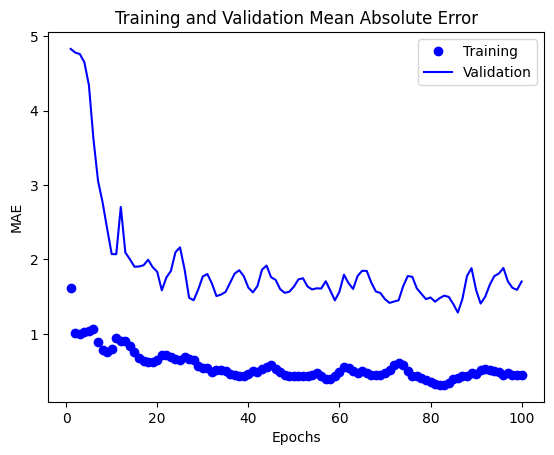

CPU times: user 3d 23h 28min 15s, sys: 15min 9s, total: 3d 23h 43min 24s
Wall time: 5h 7min 12s


In [35]:
%%time
# run k-fold cross validation
# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(augur_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

k-fold cross validation with 5 splits for 100 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0007 seconds
    creating training dataset
    elapsed time: 357.9796 seconds
    creating validation dataset
    elapsed time: 44.7395 seconds
    fitting model
    elapsed time: 14396.5426 seconds
  processing fold 1
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 362.6610 seconds
    creating validation dataset
    elapsed time: 44.2389 seconds
    fitting model
    elapsed time: 14707.9453 seconds
  processing fold 2
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 359.1062 seconds
    creating validation dataset
    elapsed time: 44.2457 seconds
    fitting model
    elapsed time: 14685.1413 seconds
  processing fold 3
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 356.0048 seconds
    creating validation dataset
    

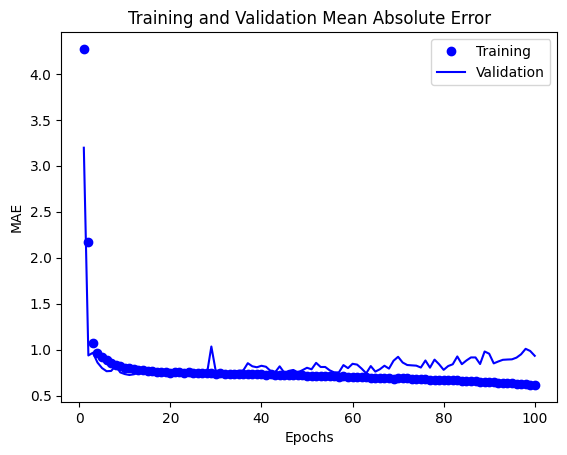

CPU times: user 14d 21h 35min 44s, sys: 9h 28min 34s, total: 15d 7h 4min 19s
Wall time: 20h 55min 17s


In [44]:
%%time
# run k-fold cross validation
# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(dan_zrimec_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [ ]:
%%time
# run k-fold cross validation
# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(dan_zrimec_model2(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

k-fold cross validation with 5 splits for 100 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 357.9630 seconds
    creating validation dataset
    elapsed time: 44.9525 seconds
    fitting model


# what are the steps?

- create ragged tensor from X_test
- create dataset from X_test and y_test

k-fold cross validation for the baseline neural network
- input is X_train, y_train
- using KFold this will be split in k folds
  - sort the trainin part
  - convert X to ragged tensor
  - create dataset
  - train
  - evaluate
- evaluate the cross fold performance
- rerun model with the whole dataset (test+val)
- save the model
```
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {i}:")
    X_train_kf, X_test_kf, y_train_kf, y_test_kf = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
    # sort X_train_kf and y_train_kf
    # convert X_train_kf to ragged tensor
    # create dataset from X_train_kf and y_train_kf
    # do the training and evaluation
# evaluate the cross fold performance
```

train/val split for the full neural network -> separate jupyter notebook
- input X_train, y_train
- split the training test set again in train and val
- create ragged tensor from training X
- create dataset from training X and y
- train
- evaluate
- rerun the model with the whole dataset (test+val)
- save the model


what have both in common?
- data load and initial prep (up to the first split)
- model setup
- training setup
- visualisation
- evaluation -> this is just one command

helpful methods
- create_dataset(X, y, sort=False)
  input X and y, specify if the dataset should be sorted
  returns a TF dataset
- run_model(model, epochs, plot=True, plot_epoch_start=0)
- plot_loss()

- callbacks
    - earlystopping -> to limit training that doesn't progress, only for the tuner
    - backupandrestore -> for the full training as fault tolerance setup
    - modelcheckpoint -> to save the best model on the final train

In [ ]:
# split the train set again in train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1202)

In [ ]:
# find the first unique PTR value that is also in y_train
train_idx = 0
for i in range(len(y)):
    count = 0
    for l in range(len(y)):
        if i != l and y[i] == y[l]:
            count += 1
            continue
    if count == 0:
        for m in range(len(y_train)):
            if y[i] == y_train[m]:
                train_idx = m
                break
train_idx

In [ ]:
# get a sample
X_train[train_idx]

In [ ]:
# get the matching target
search_y = y_train[train_idx]
search_y

In [ ]:
# find the target value in the raw dataset
full_idx = 0
for i in range(len(y)):
    if y[i] == search_y:
        print(i)
        full_idx = i

In [ ]:
# compare if the raw dataset entry matches the subset entry
if X[full_idx].all() == X_train[train_idx].all():
    print('OK')

### Sort Training Data

In [ ]:
# build an inhomogenous numpy array from the training set
X_train = np.array(X_train, dtype=object)

In [ ]:
# build an array containing the sequence lengths
sequence_lengths = list(map(lambda x: len(x), X_train))

In [ ]:
# sort the array but only get the indices
sorted_indices = np.argsort(sequence_lengths)

In [ ]:
sorted_indices

In [ ]:
# now sort the X and y train arrays according to the sorted indicds
X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]

In [ ]:
# check if the previously found values still correlate
for i in range(len(y_train)):
    if y_train[i] == search_y:
        print(X_train[i])

### Ragged Tensor Tests

In [ ]:
# this does not work since the sequences are of different length
# X_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
%%time
X_train_tensor = tf.ragged.constant(X_train, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
X_val_tensor = tf.ragged.constant(X_val, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)

In [ ]:
X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train))
X_val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val))

In [ ]:
X_train_dataset.element_spec

In [ ]:
X_val_dataset.element_spec

In [ ]:
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

In [ ]:
X_train_dataset = X_train_dataset.map(reformat)
X_val_dataset = X_val_dataset.map(reformat)

In [ ]:
# shuffle the dataset (again) and create padded batches
batch_size = 64
X_train_dataset = X_train_dataset.padded_batch(batch_size)
X_val_dataset = X_val_dataset.shuffle(buffer_size=len(X_val), seed=1202).padded_batch(batch_size)

In [ ]:
# optinally repeat the dataset multiple times -> WHY?
# rep = 3
# X_train_dataset = X_train_dataset.repeat(rep)
# X_val_dataset = X_val_dataset.repeat(rep)

In [ ]:
datalen = []
ds_iterator = iter(X_train_dataset)
for data, label in ds_iterator:
    datalen.append(len(data[1]))

In [ ]:
datalen[:5]

In [ ]:
# testing if keras can use the dataset
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(None,4)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_dataset, epochs=1)